In [1]:
import pandas as pd
import sklearn
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
%matplotlib inline
from sklearn import preprocessing
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DataConversionWarning)

In [2]:
#preprocessing
def removeUnknown(df_in, col, match):
    df = df_in.copy()

    df = df.loc[df[col] != match]
    return df

df = pd.read_csv('terrorism_new.csv')
cols = ['iyear', 'extended', 'latitude', 'longitude', 'attacktype1', 'success', 'suicide', 'targtype1', 'gname', 'nperps', 'nkill', 'nwound', 'property']
df = df.loc[:, cols]

#remove all unknown
for col in cols:
    df = removeUnknown(df, col, 'Unknown')
    df = removeUnknown(df, col, -9)
    df = removeUnknown(df, col, -99)
    
df = df.dropna()
df.to_csv('trimmed_dataset.csv', index = False)


/Users/xiaoqi.lim/Desktop/FYP/data-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (4,31,33,61,62,63,76,79,90,92,94,96,114,115,121) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
def preprocess_data(dataset, incident_count):
    #remove Unknown terrorist groups
    dataset = dataset[dataset['gname'] != "Unknown"]
    #drop rows with NaN values
    dataset = dataset.dropna()
    
    #attack counts per group
    group_attack_count = {}
    for i in dataset['gname']:
        if i in group_attack_count:
            group_attack_count[i] = 1 + group_attack_count[i]
        else:
            group_attack_count[i] = 1
            
    #list to determine which rows to discard later on (if in this list, gname has <500 attacks)
    to_discard = []
    for i in group_attack_count:
        if group_attack_count[i] < incident_count:
            to_discard.append(i)
            
    #map that contains gnames and their attack counts (must have >= 500 attacks)
    #this map is not used in model building, but is useful to see spread of attacks across gnames we are interested in
    to_keep_map = {}
    for i in group_attack_count:
        if group_attack_count[i] >= incident_count:
            to_keep_map[i] = group_attack_count[i]
    
    #trim dataset to only include gnames we are interested in, we are not interested in gnames that are in to_discard
    dataset = dataset[~dataset['gname'].isin(to_discard)]
    
    #make a dictionary to map each gname to a number
    name_map = {}
    unique_gname = dataset['gname'].unique()
    for i in range(len(unique_gname)):
        name_map[unique_gname[i]] = i
    
    dataset = dataset.replace({"gname":name_map})
    
    return dataset

In [4]:
def plotPrecisionRecall(recall_micro, precision_micro, avgPrecise_micro):
    plt.figure()
    plt.step(recall_micro, precision_micro, where='post')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(
        'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
        .format(avgPrecise_micro))

In [5]:
def plotPrecisionRecallBinary(forest_classifier, X_test, y_test, average_precision):
    disp = plot_precision_recall_curve(forest_classifier, X_test, y_test)
    disp.ax_.set_title('2-class Precision-Recall curve: '
                       'AP={0:0.2f}'.format(average_precision))

In [6]:
def gridSearch(dataset, output_label, verbose=2):
    X = dataset.drop(output_label, axis = 1)

    Y = label_binarize(dataset[output_label], classes=np.arange(len(dataset[output_label].unique())))
    n_classes = Y.shape[1]
    
    param_grid = {
    'n_estimators' : [100, 250],
    'max_features': ['sqrt', 'log2', None],
    'min_samples_leaf' : [1, 100, 250],
    }
    
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)
    
    rf = RandomForestClassifier()
    clf = GridSearchCV(rf, param_grid, verbose = verbose, scoring = 'f1_macro')
    clf.fit(X_train, y_train)
    
    forest_classifier = clf.best_estimator_
    
    # Instantiate model with 1000 decision trees
#     forest_classifier = RandomForestClassifier(n_estimators = 100)
    # Train the model on training data
    forest_classifier.fit(X_train, y_train);
    print("The accuracy is: ", forest_classifier.score(X_test, y_test))
    
    y_score = forest_classifier.predict(X_test)
    
    print("The F1 score is: {}".format(f1_score(y_test, y_score, average = 'macro')))
    
    if output_label == 'success':
        average_precision = average_precision_score(y_test, y_score)
        print('Average precision-recall score: {0:0.2f}'.format(
              average_precision))
        plotPrecisionRecallBinary(forest_classifier, X_test, y_test, average_precision)
    else:
        # For each class
        precision = dict()
        recall = dict()
        average_precision = dict()
        for i in range(n_classes):
            precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                                y_score[:, i])
            average_precision[i] = average_precision_score(y_test[:, i], y_score[:, i])

        # A "micro-average": quantifying score on all classes jointly
        precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(),
            y_score.ravel())
        average_precision["micro"] = average_precision_score(y_test, y_score,
                                                             average="micro")
        print('Average precision score, micro-averaged over all classes: {0:0.2f}'
              .format(average_precision["micro"]))
        plotPrecisionRecall(recall['micro'], precision['micro'],average_precision["micro"])

In [11]:
def wrapper(output_label):
    rfe_dict = {
        "success" : ['iyear', 'latitude', 'longitude', 'attacktype1', 'nkill', 'nwound', 'targtype1', 'property', 'gname', 'nperps', 'suicide', 'extended', 'success'],
        "gname" : ["iyear", "latitude", "longitude", "targtype1", "nperps", "nkill", "gname"],
        "targtype1" : ["iyear", "lat", "long", "nperps", "gname", "nkill", "nwound", "property", "attacktype1", "success", "suicide", "targtype1"]
    }

    df = preprocess_data(pd.read_csv('trimmed_dataset.csv'),0)
    label = "success"
    cols = rfe_dict[label]
    df = df[cols]
    # df = preprocess_data(pd.read_csv('trimmed_dataset.csv'), 0)
    print("Predicting Label: {}".format(label))
    gridSearch(df, label, 1)

Predicting Label: success
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


The accuracy is:  0.9013657056145675
The F1 score is: 0.7858517685289339
Average precision-recall score: 0.94


[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    0.6s finished


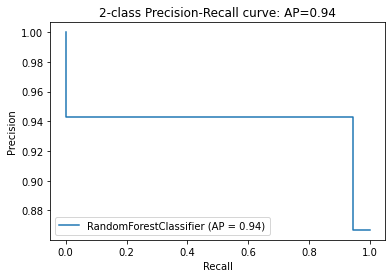

In [12]:
wrapper("success")

Predicting Label: success
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


The accuracy is:  0.9035334923043572
The F1 score is: 0.7919942323778217
Average precision-recall score: 0.94


[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    0.7s finished


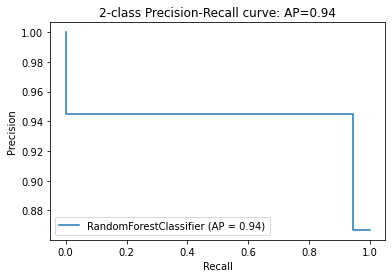

In [13]:
wrapper("gname")


Predicting Label: success
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


The accuracy is:  0.9100368523737264
The F1 score is: 0.8049476029654481
Average precision-recall score: 0.94


[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    0.7s finished


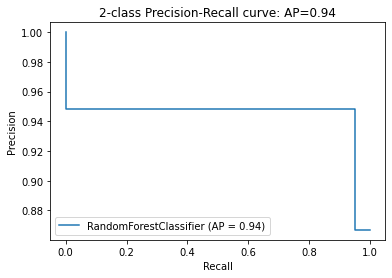

In [14]:
wrapper("targtype1")